In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
pi = np.pi

# obrazek powinien byc tak
# /\
# |
# |
# |
# (0,0)------->

In [2]:
img = mpimg.imread('tomograf-zdjecia/Kwadraty2.jpg')[:,:,2] / 255

picHeight = img.shape[0]
picWidth = img.shape[1]

r =  np.sqrt( picWidth**2 + picHeight**2 ) /2

print(picWidth)
print(picWidth)
print(r)

#plt.imshow(img)

384
384
271.5290039756342


In [3]:
def transformToPictureCoordinates(point, picHeight, picWidth):
    X = point[0] + (0.5*picWidth)
    Y = point[1] + (0.5*picHeight)
    
    X = int(np.floor(X))
    Y = int(np.floor(Y))
    return ( X, Y )

def getSource(alfa, r):
    Xe = r * np.cos(alfa)
    Ye = r * np.sin(alfa)
    
    return (Xe, Ye)

#n - ilosc detektorow, alfa - przesuniecie wszystkeigo, phi - rozstawienie detektorow, r - promien kola
def getDetectors(n, alfa, phi, r):
    detectors = []
    
    # D0
    Xd = r * np.cos(alfa + pi - (phi/2))
    Yd = r * np.sin(alfa + pi - (phi/2))

    detectors.append( (Xd, Yd) )
    
    # D1 ... Dn-1
    for i in range(1,n):
        Xd = r * np.cos(alfa + pi - (phi/2) + (i * (phi/(n-1))))
        Yd = r * np.sin(alfa + pi - (phi/2) + (i * (phi/(n-1))))
        
        detectors.append( (Xd, Yd) )
    
    return detectors

In [4]:
def bresenhamL(x1, y1, x2, y2):
    points = []
    dx = x2 - x1
    dy = y2 - y1
    m = 1
    if dy < 0:
        m = -1
        dy = -dy
    j = y1
    e = (2 * dy) - dx
    
    for i in range(x1, x2):
        points.append((i, j))
        if e > 0:
            j += m
            e += 2 * (dy - dx)
        else:
            e += 2 * dy
    return points

def bresenhamH(x1, y1, x2, y2):
    points = []
    dx = x2 - x1
    dy = y2 - y1
    m = 1
    if dx < 0:
        m = -1
        dx = -dx
    i = x1
    e = (2 * dx) - dy
    
    for j in range(y1, y2):
        points.append((i, j))
        if e > 0:
            i += m
            e += 2 * (dx - dy)
        else:
            e += 2 * dx
    return points

def bresenham(x1, y1, x2, y2):
    if abs(y2 - y1) < abs(x2 - x1):
        if x1 > x2:
            return bresenhamL(x2, y2, x1, y1)
        else:
            return bresenhamL(x1, y1, x2, y2)
    else:
        if y1 > y2:
            return bresenhamH(x2, y2, x1, y1)
        else:
            return bresenhamH(x1, y1, x2, y2)

In [5]:
def absorption(img, x1, y1, x2, y2):
    height = img.shape[0]
    width = img.shape[1]
    
    s = 0
    
    for (x, y) in bresenham(x1, y1, x2, y2):
        if x >= 0 and x < width and y >= 0 and y < height:
            s += img[x][y]
    return s

In [6]:
def img2sinogram(img, alfaDelta, n, phi):
    alfaDelta = np.radians(alfaDelta)
    phi = np.radians(phi)
    
    picHeight = img.shape[0]
    picWidth = img.shape[1]
    d = np.sqrt( picWidth**2 + picHeight**2 )
    r =  d / 2
    
    lines = []
    alfa = 0
    while alfa < pi:
        
        source = getSource(alfa, r)
        pSource = transformToPictureCoordinates(source, picWidth, picHeight)
        
        detectors = getDetectors(n, alfa, phi, r)
        pDetectors = [transformToPictureCoordinates(x, picWidth, picHeight) for x in detectors]
        
        line = []
        
        for detector in pDetectors:
            a = absorption(img, pSource[0], pSource[1], detector[0], detector[1])
            line.append(a)
            
        
        lines.append(line)
        alfa += alfaDelta
    
    maxValue = max(map(max, lines))
    normalized = [[v / maxValue for v in line] for line in lines]
    
    #plt.imshow(normalized, cmap='binary_r')
    return np.stack(normalized, axis=0)

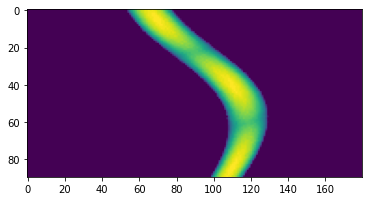

In [7]:
plt.imshow(img2sinogram(img, 2, 180, 180))

In [ ]:
# n = 4
# phi = np.radians(180)
# alfa = np.radians(90)

# picHeight = img.shape[0]
# picWidth = img.shape[1]
# print("Wysokość:", picHeight, "Szerokość:", picWidth)

# d = np.sqrt( picWidth**2 + picHeight**2 )
# r =  d / 2
# print("Promień: ", r)

# source = getSource(alfa, r)
# pSource = transformToPictureCoordinates(source, picWidth, picHeight)
# print("Source:", pSource)

# detectors = getDetectors(n, alfa, phi, r)
# pDetectors = [transformToPictureCoordinates(x, picWidth, picHeight) for x in detectors]
# print(pDetectors)

In [ ]:
# TESTY

# wspolrzedne abstrakcyjne
source = getSource(pi+pi/4, r)
detectors = getDetectors(3, pi+pi/4, pi/2, r)

# wspolrzedne na obrazku
pSource = transformToPictureCoordinates(source, picWidth, picHeight)
pDetectors = [transformToPictureCoordinates(x, picWidth, picHeight) for x in detectors]

print(pSource)
print(pDetectors)
# ------------------

In [7]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def interactive_sinogram(sinogram):
    max_iterations = len(sinogram)
    
    def draw_part_of_sinogram(sinogram, iteration):
        l  = [(line if i < iteration else [0] * len(line)) for i, line in enumerate(sinogram)]
        plt.imshow(l, cmap='binary_r')
        #return iteration

    interact(draw_part_of_sinogram, sinogram = fixed(sinogram), iteration = widgets.IntSlider(min=1, max=max_iterations, step=1, value=max_iterations))

sinogram = img2sinogram(img, 2, 180, 180)
interactive_sinogram(sinogram)

interactive(children=(IntSlider(value=90, description='iteration', max=90, min=1), Output()), _dom_classes=('w…

In [24]:
def sinogram2img(sin, picHeight, picWidth, phi, iteration, filtered):
    sinHeight = sin.shape[0]
    sinWidth = sin.shape[1]
    phi = np.radians(phi)
    d = np.sqrt( picWidth**2 + picHeight**2 )
    r =  d / 2
    
    alfaDelta = np.radians(180 / sinHeight)
    n = sinWidth
    
    img = np.zeros((picHeight, picWidth))
    
    alfa = 0
    line = 0
    while alfa < pi and line < iteration:
        
        source = getSource(alfa, r)
        pSource = transformToPictureCoordinates(source, picWidth, picHeight)
        
        detectors = getDetectors(n, alfa, phi, r)
        pDetectors = [transformToPictureCoordinates(x, picWidth, picHeight) for x in detectors]
        #print("D", len(detectors))
        
        for row, detector in enumerate(pDetectors):
            for (x, y) in bresenham(pSource[0], pSource[1], detector[0], detector[1]):
                if x >= 0 and x < picWidth and y >= 0 and y < picHeight:
                    img[y][x] += sin[line][row]
            
        
        alfa += alfaDelta
        line += 1
        
    maxValue = img.max()
    normalized = [[v / maxValue for v in line] for line in img]
    
    plt.imshow(normalized)

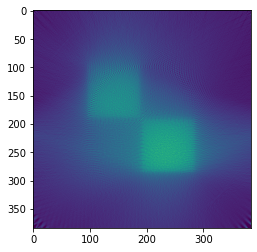

In [25]:
sinogram2img(sinogram, 384, 384, 180, 90, False)

In [15]:
def interactive_output(sinogram):
    max_iterations = sinogram.shape[0]
    
    interact(sinogram2img, sin = fixed(sinogram), picHeight = fixed(384), picWidth = fixed(384), phi = fixed(180), iteration=widgets.IntSlider(min=1, max=max_iterations, step=1, value=1), filtered=False)
    
interactive_output(sinogram)

interactive(children=(IntSlider(value=1, description='iteration', max=90, min=1), Checkbox(value=False, descri…